# Graph Neural Networks in integrative omics - Lab notebook
- Sergiu Netotea, NBIS, 2024



## Word2Vec example: clustering in the karate club graph

Here's a simple application of Node2Vec using PyTorch and PyTorch Geometric to perform node embedding on a small graph. In this example, we'll use the torch_geometric library to load a dataset, apply the Node2Vec model, and visualize the learned embeddings. We'll use a toy dataset from torch_geometric.datasets for simplicity. We'll use the popular Karate Club graph dataset, which is a small graph representing social interactions in a karate club. It contains 34 nodes (members) and 78 edges (interactions between members).

This example shows how to use Node2Vec from PyTorch Geometric to generate node embeddings from a graph. After training the model, we reduce the dimensionality using t-SNE and visualize the node embeddings in a 2D space. The coloring of nodes indicates their class (community) labels, showing that nodes with similar labels are placed close together in the embedding space.

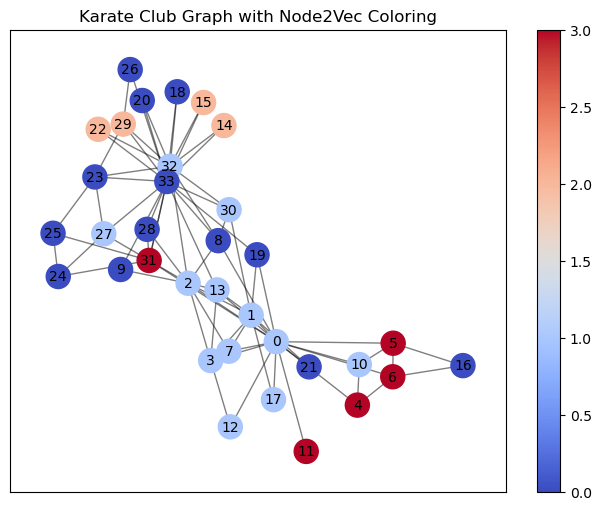

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import KarateClub
import numpy as np

# Load the Karate Club graph dataset
dataset = KarateClub()
data = dataset[0]

# Convert PyTorch geometric data to NetworkX format
G = nx.Graph()

# Add edges to the NetworkX graph
edges = data.edge_index.t().tolist()
G.add_edges_from(edges)

# Get node labels (used for coloring)
node_labels = data.y.numpy() if torch.is_tensor(data.y) else data.y

# Define the position layout for the graph
pos = nx.spring_layout(G, seed=42)

# Plot the graph with node colors based on their label using the same color map
plt.figure(figsize=(8, 6))
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_labels, cmap='coolwarm', node_size=300, 
                               nodelist=G.nodes(), node_shape='o')
edges = nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)

# Add colorbar for the nodes
plt.colorbar(nodes)
plt.title("Karate Club Graph with Node2Vec Coloring")
plt.show()

In [5]:
print(data.y)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


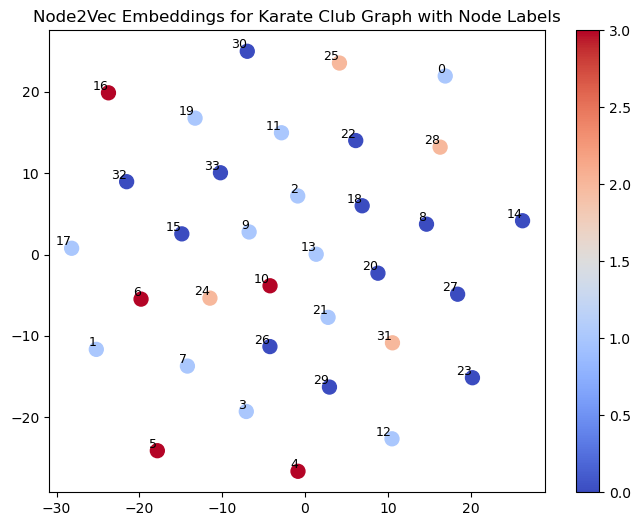

In [9]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import Node2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the Karate Club graph dataset
dataset = KarateClub()
data = dataset[0]

# Define Node2Vec model
embedding_dim = 64  # Number of dimensions for the node embeddings
walk_length = 20  # Length of each random walk
context_size = 10  # Window size in Skip-Gram model
num_walks_per_node = 10  # Number of random walks per node
p = 1  # Return hyperparameter
q = 1  # In-out hyperparameter

node2vec = Node2Vec(
    data.edge_index, 
    embedding_dim=embedding_dim, 
    walk_length=walk_length,
    context_size=context_size, 
    walks_per_node=num_walks_per_node, 
    p=p, 
    q=q,
    sparse=True  # Use sparse gradients to save memory
).to('cpu')

# Define the optimizer
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

# Training loop
def train():
    node2vec.train()
    total_loss = 0
    for epoch in range(100):  # Train for 100 epochs
        optimizer.zero_grad()
        # Select a batch of nodes (in this case, all nodes)
        batch = torch.arange(data.num_nodes, device='cpu')
        # Generate positive and negative random walks for the batch
        pos_rw = node2vec.pos_sample(batch)
        neg_rw = node2vec.neg_sample(batch)
        # Calculate loss
        loss = node2vec.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / 100

# Train the Node2Vec model
loss = train()

# Get the learned node embeddings
node_embeddings = node2vec.embedding.weight.data.cpu()

# Convert the PyTorch tensor to a NumPy array
node_embeddings_np = node_embeddings.numpy()

# Apply t-SNE to reduce dimensions for visualization
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings_np).astype('float64')  # Ensure t-SNE output is float64

# Plot the embeddings
plt.figure(figsize=(8, 6))

# Ensure node_embeddings_2d is float64 and data.y is converted to NumPy if needed
sc = plt.scatter(
    node_embeddings_2d[:, 0].astype('float64'), 
    node_embeddings_2d[:, 1].astype('float64'), 
    c=data.y.numpy() if torch.is_tensor(data.y) else data.y,  # Labels for coloring the points
    cmap='coolwarm', 
    s=100
)

# Add node labels
for i, (x, y) in enumerate(node_embeddings_2d):
    plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')

# Add colorbar for the nodes
plt.colorbar(sc)
plt.title("Node2Vec Embeddings for Karate Club Graph with Node Labels")
plt.show()


## GCN example: graph citation networks

Graph Convolutional Networks (GCNs) are a type of neural network designed to operate on graph-structured data. We will start with a simple application of performing node classification in a graph. For example, in a citation network, nodes represent documents, edges represent citations between them, and the goal is to classify each document into predefined categories (e.g., "AI", "Physics", etc.).

In this first example, we’ll use a simple synthetic graph dataset to perform node classification. We'll generate a small graph where each node has a feature vector and belongs to one of two classes. Then, we’ll implement a basic GCN to classify nodes based on their neighbors' features and graph structure.

__Dataset Generation:__
- We’ll generate a graph with 20 nodes. Each node will have a feature vector (say, a 5-dimensional vector). The nodes will be connected based on a predefined adjacency matrix (20% chance of edge formation). We'll assign labels (2 classes) to nodes randomly. The GCN should be able to classify the nodes based on their features and the graph structure. The accuracy will depend on the randomness of the dataset and the structure of the graph.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

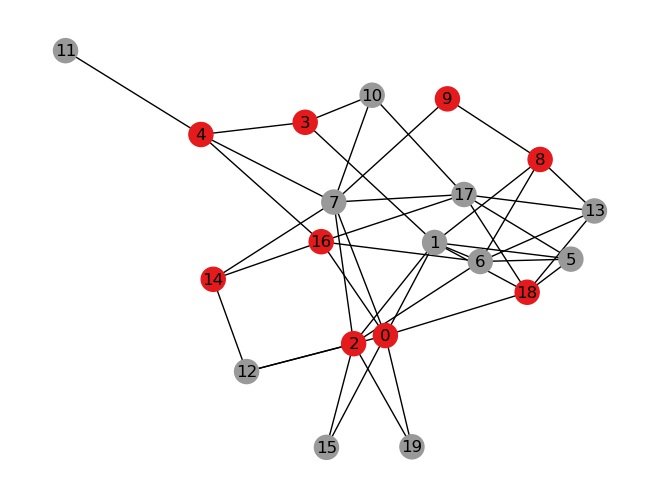

Feature Matrix Shape: (20, 5)
Adjacency Matrix Shape: (20, 20)
Labels: [0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1]


In [2]:
np.random.seed(42)

# Generate the synthetic citation network dataset
def generate_synthetic_graph(num_nodes=20, num_features=5, num_classes=2):
    # Generate a random feature matrix (each node has a num_features-dimensional feature vector)
    feature_matrix = np.random.randn(num_nodes, num_features)
    # Create a random adjacency matrix
    G = nx.erdos_renyi_graph(num_nodes, 0.2)  # probability of edge creation is 0.2
    # Get the adjacency matrix as a sparse matrix
    adj_matrix_sparse = nx.adjacency_matrix(G)
    # Convert the sparse matrix to a dense numpy array (optional)
    adjacency_matrix = adj_matrix_sparse.toarray()
    # Generate random labels for each node (num_classes possible classes)
    labels = np.random.randint(0, num_classes, size=num_nodes)
    return feature_matrix, adjacency_matrix, labels, G

# Generate the dataset
num_nodes = 20
features, adjacency, labels, graph = generate_synthetic_graph(num_nodes=num_nodes)

# Visualize the graph
nx.draw(graph, with_labels=True, node_color=labels, cmap=plt.get_cmap('Set1'))
plt.show()

print("Feature Matrix Shape:", features.shape)
print("Adjacency Matrix Shape:", adjacency.shape)
print("Labels:", labels)

__GCN Implementation:__

- we implement the Graph Convolutional Network (GCN) using PyTorch Geometric, a library designed for graph-based deep learning.
- The GCN will take the feature matrix and the adjacency matrix as input and produce predictions for node classes.

In [47]:
# Train/Test split (use integers for mask)
#train_mask_np, test_mask_np = train_test_split(np.arange(num_nodes), test_size=0.2, random_state=42)

# Assume test_nodes_list contains the indices of the selected test nodes
test_nodes_list = [18, 16]  # Example list of test node indices
# Define test_mask_np based on the selected test nodes
test_mask_np = np.array(test_nodes_list)
# Define train_mask_np as all nodes except the test nodes
train_mask_np = np.setdiff1d(np.arange(num_nodes), test_mask_np)


# Convert to PyTorch Long Tensors
train_mask = torch.tensor(train_mask_np, dtype=torch.long)  # Convert train_mask to PyTorch tensor
test_mask = torch.tensor(test_mask_np, dtype=torch.long)    # Convert test_mask to PyTorch tensor

# Convert the dataset to PyTorch tensors
edge_index = torch.tensor(np.array(graph.edges()).T, dtype=torch.long)  # Edge index for PyTorch Geometric
x = torch.tensor(features, dtype=torch.float)  # Feature matrix
y = torch.tensor(labels, dtype=torch.long)     # Labels

# Get the training nodes (nodes not in test_mask)
train_nodes = np.setdiff1d(np.arange(len(labels)), test_mask_np)

__Defining the GCN model:__

- GCN Layers: The GCNConv layers perform the graph convolution operation. We use two layers:
    - The first layer transforms the input features into a hidden layer.
    - The second layer outputs the class predictions.
- Training Loop: The model is trained using gradient descent with the Adam optimizer. We evaluate the accuracy on the test nodes every 10 epochs.

In [48]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First convolution layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # Second convolution layer
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Model training
model = GCN(in_channels=features.shape[1], hidden_channels=16, out_channels=2)  # 5 input features, 16 hidden units, 2 output classes
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

In [49]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index)
    # Use train_mask as indices for loss calculation
    loss = loss_fn(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(x, edge_index)
    pred = out.argmax(dim=1)  # Get predicted class (highest log probability)
    test_correct = pred[test_mask] == y[test_mask]
    test_acc = int(test_correct.sum()) / int(test_mask.size(0))
    return test_acc

# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 0, Loss: 0.5578, Test Accuracy: 0.5000
Epoch: 10, Loss: 0.3876, Test Accuracy: 0.5000
Epoch: 20, Loss: 0.3196, Test Accuracy: 0.5000
Epoch: 30, Loss: 0.2702, Test Accuracy: 0.5000
Epoch: 40, Loss: 0.2289, Test Accuracy: 0.5000
Epoch: 50, Loss: 0.1932, Test Accuracy: 0.5000
Epoch: 60, Loss: 0.1618, Test Accuracy: 1.0000
Epoch: 70, Loss: 0.1344, Test Accuracy: 1.0000
Epoch: 80, Loss: 0.1130, Test Accuracy: 1.0000
Epoch: 90, Loss: 0.0956, Test Accuracy: 0.5000


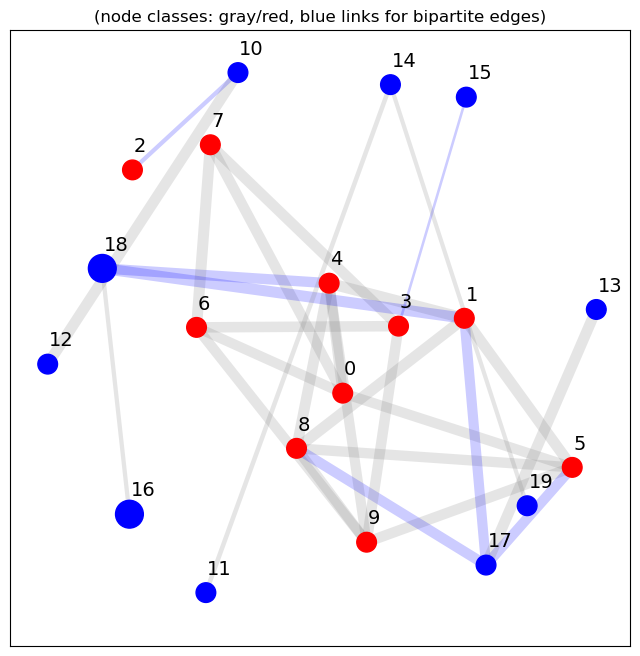

In [44]:
# Plot the graph
# Using a spring layout with a minimum edge length for better visualization
pos = nx.spring_layout(graph, k=3.5, iterations=100)  # Adjusting 'k' for minimum length of edges

plt.figure(figsize=(8, 8))
for edge in graph.edges(data=True):
    node1, node2, weight = edge
    color = 'gray' if labels[node1] == labels[node2] else 'blue'
    # weight will be defined later
    if weight:
        nx.draw_networkx_edges(graph, pos, edgelist=[(node1, node2)], width=weight['weight'] * 5, edge_color=color, alpha=0.2)
    else:
        nx.draw_networkx_edges(graph, pos, edgelist=[(node1, node2)], width=1, edge_color=color, alpha=0.2)
# Draw nodes with larger labels positioned above and to the right
colors = ["red", "blue"]
node_colors = [colors[labels[i]] for i in graph.nodes()]
node_sizes = [400 if i in set(test_mask_np) else 200 for i in graph.nodes()]
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors)
# Compute the label positions more precisely
label_pos = {k: pos[k] + np.array([0.005, 0.05]) for k in pos}
nx.draw_networkx_labels(graph, label_pos, font_size=14, font_color="black", verticalalignment='bottom', horizontalalignment='left')

plt.title("(node classes: gray/red, blue links for bipartite edges)")
plt.show()

In [45]:
# Test the model based on input (test on a specific node)
def test_single_node(node_idx):
    model.eval()
    out = model(x, edge_index)
    pred = out.argmax(dim=1)
    predicted_class = pred[node_idx].item()
    actual_class = y[node_idx].item()
    print(f"Node {node_idx}: Predicted Class = {predicted_class}, Actual Class = {actual_class}")

# Test the model on a specific node from the test set
for node_idx in test_mask:
    test_single_node(node_idx.item())

Node 18: Predicted Class = 0, Actual Class = 1
Node 16: Predicted Class = 1, Actual Class = 1


In order to get better models, one needs to use better data, so let us generate a better dataset. Which is also a useful graph exercise! Programming should be done by writing tests first, so the ability to generate insilico datasets is very useful in multi-omics.

If you return here from setting up a 

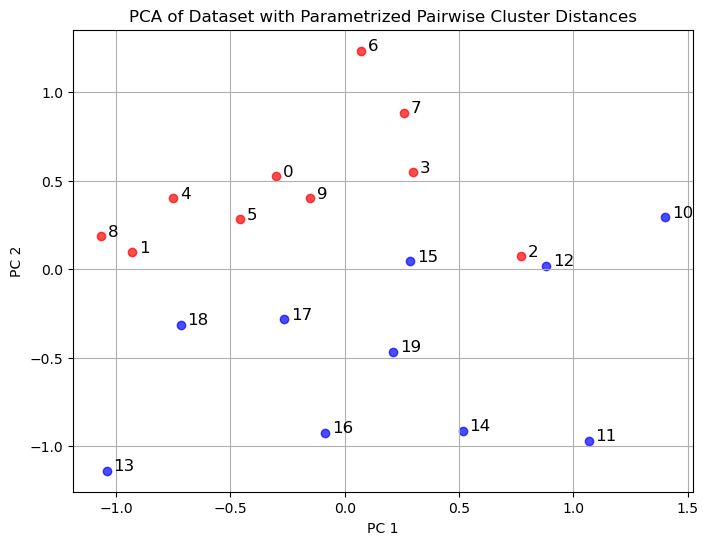

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 20  # Total number of samples
n_features = 5  # Number of features
n_clusters = 2  # Number of clusters
cluster_spread = 0.5  # Spread of points around cluster centers

# Define a pairwise distance matrix between clusters
"""
# Example: pairwise distances for 4 clusters
distance_matrix = np.array([
    [0, 3, 2, 5],
    [3, 0, 4, 6],
    [2, 4, 0, 3],
    [5, 6, 3, 0]
])
"""

distance_matrix = np.array([
    [0, 1],
    [1, 0],
])

# Use Multidimensional Scaling (MDS) to find coordinates of the cluster centers in 2D latent space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
latent_factors_centers = mds.fit_transform(distance_matrix)

# Assign samples to clusters and generate latent factors for each sample
samples_per_cluster = n_samples // n_clusters
latent_factors = np.zeros((n_samples, 2))

for i in range(n_clusters):
    cluster_start = i * samples_per_cluster
    cluster_end = (i + 1) * samples_per_cluster
    latent_factors[cluster_start:cluster_end, 0] = np.random.normal(
        loc=latent_factors_centers[i, 0], scale=cluster_spread, size=samples_per_cluster
    )  # First latent factor (influences PCA1)
    latent_factors[cluster_start:cluster_end, 1] = np.random.normal(
        loc=latent_factors_centers[i, 1], scale=cluster_spread, size=samples_per_cluster
    )  # Second latent factor (influences PCA2)

# Generate observed features as linear combinations of latent factors plus some noise
W = np.random.rand(2, n_features)  # Random weights for mapping latent factors to features
noise = np.random.normal(0, 0.3, size=(n_samples, n_features))  # Adding some noise for realism
X = np.dot(latent_factors, W) + noise  # Map latent factors to observed features with noise

# Convert to a dataframe for easier visualization
df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(n_features)])

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange', 'magenta']


labels = np.array([0] * n_samples) # initialize labels as zeroes
for i in range(n_clusters):
    cluster_start = i * samples_per_cluster
    cluster_end = (i + 1) * samples_per_cluster
    for j in range(cluster_start,cluster_end):
        labels[j] = i
        plt.scatter(X_pca[j, 0], X_pca[j, 1], alpha=0.7, color=colors[i])
        plt.text(X_pca[j, 0] + 0.03, X_pca[j, 1], str(j), fontsize=12)
plt.title('PCA of Dataset with Parametrized Pairwise Cluster Distances')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()



In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Graph extraction using a threshold
threshold = 0.7
num_samples = n_samples
graph = nx.Graph()

for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if similarity_matrix[i, j] > threshold:
            graph.add_edge(i, j, weight=1.7**similarity_matrix[i, j])

# Find and add any missing nodes
for node in range(num_samples):
    if node not in graph.nodes:
        # Find the closest neighbor for the missing node
        #closest_neighbor = np.argmax(similarity_matrix[node])
        # Get the similarities, excluding the node itself by setting its value to -1
        similarities = similarity_matrix[node].copy()
        similarities[node] = -1  # Exclude self-similarity
        closest_neighbor = np.argmax(similarities)
        graph.add_edge(node, closest_neighbor, weight=similarity_matrix[node, closest_neighbor])

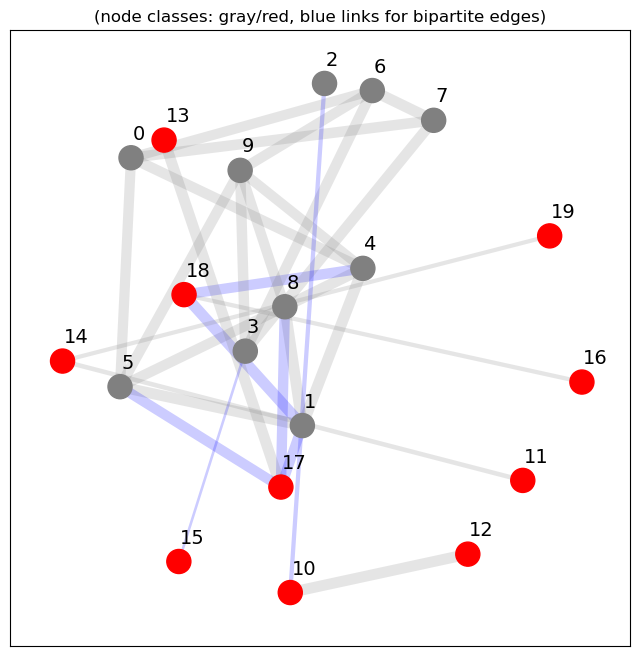

In [32]:
# Plot the graph
# Using a spring layout with a minimum edge length for better visualization
pos = nx.spring_layout(graph, k=3.5, iterations=100)  # Adjusting 'k' for minimum length of edges

plt.figure(figsize=(8, 8))
for edge in graph.edges(data=True):
    node1, node2, weight = edge
    color = 'gray' if labels[node1] == labels[node2] else 'blue'
    nx.draw_networkx_edges(graph, pos, edgelist=[(node1, node2)], width=weight['weight'] * 5, edge_color=color, alpha=0.2)

# Draw nodes with larger labels positioned above and to the right
nx.draw_networkx_nodes(graph, pos, node_size=300, node_color=['red' if labels[i] == 1 else 'gray' for i in graph.nodes()])
label_pos = {k: pos[k] + np.array([0.005, 0.05]) for k in pos}
nx.draw_networkx_labels(graph, label_pos, font_size=14, font_color="black", verticalalignment='bottom', horizontalalignment='left')

plt.title("(node classes: gray/red, blue links for bipartite edges)")
plt.show()

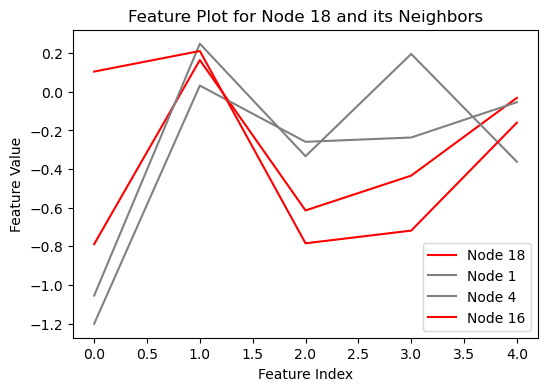

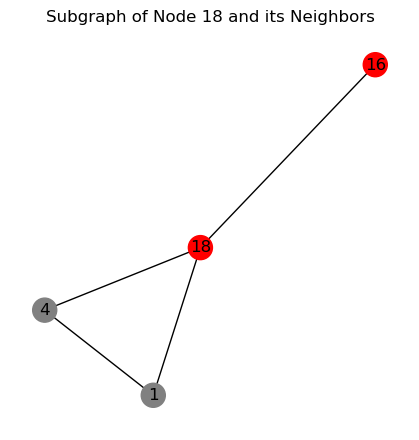

In [33]:
# Pick a vertex to analyze
picked_vertex = 18

# Line plotting its neighbors
neighbors = list(graph.neighbors(picked_vertex))
nodes_to_plot = [picked_vertex] + neighbors
plt.figure(figsize=(6, 4))
for node in nodes_to_plot:
    color = 'gray' if labels[node] == 0 else 'red'
    plt.plot(X[node], label=f'Node {node}', color=color)

plt.title(f"Feature Plot for Node {picked_vertex} and its Neighbors")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# Subgraph of picked vertex's neighbors
subgraph = graph.subgraph([picked_vertex] + neighbors)

plt.figure(figsize=(4, 4))
nx.draw(subgraph, with_labels=True, node_color=['red' if labels[i] == 1 else 'gray' for i in subgraph.nodes()], node_size=300, pos=nx.spring_layout(subgraph), font_size=12)
plt.title(f"Subgraph of Node {picked_vertex} and its Neighbors")
plt.show()

In [46]:
# graph was already computed
# labels was already computed
num_nodes = n_samples
features = X
# Get the adjacency matrix as a sparse matrix
adj_matrix_sparse = nx.adjacency_matrix(graph)
# Convert the sparse matrix to a dense numpy array (optional)
adjacency_matrix = adj_matrix_sparse.toarray()

Now return to the first network training and let's see if we can improve our score!


__Questions:__
- How could this model be applied in a multi-omics context?

## Clustering with a GCN

__Question:__ How would you adapt the citation model to cluster cell types in a dataset that consists of single cell data?

GCN clustering cell types from single-cell data can be an effective approach, particularly when capturing relationships between cells in the form of a graph structure. Here’s how you can adapt the citation model we discussed earlier for single-cell data:

- __Single-Cell Dataset__
    - Gene expression matrix: Each row corresponds to a single cell, and each column corresponds to a gene. The entries in this matrix represent the expression levels of genes in individual cells.
    - Cell metadata: Information about cells (if available), like known cell types, conditions, or other phenotypic traits.
- __Graph Structure in Single-Cell Data.__ To apply a GCN, we need to represent the single-cell dataset as a graph. The idea is to:
    - Our approach: nodes represent individual cells while edges connect similar cells based on some similarity metric (like gene expression similarity).
    - Other approaches: Links may be defined using more complex patterns, such as in Cellograph where they denote connections between transcriptionally similar cells (ATAC-Seq based). Other studies can infer cell links based on other omics types.


In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

expression_matrix = X

# Assume `expression_matrix` is the gene expression data (cells x genes)
# Normalize the expression matrix
normalized_expression = expression_matrix / np.linalg.norm(expression_matrix, axis=1, keepdims=True)

# Compute the similarity matrix between cells (e.g., cosine similarity)
similarity_matrix = cosine_similarity(normalized_expression)

# Generate adjacency matrix (e.g., using k-NN with thresholding)
k = 5  # Number of nearest neighbors to connect
adjacency_matrix = np.zeros(similarity_matrix.shape)
for i in range(similarity_matrix.shape[0]):
    # Get indices of k nearest neighbors
    knn_indices = np.argsort(similarity_matrix[i])[-(k+1):-1]  # Exclude the cell itself
    adjacency_matrix[i, knn_indices] = 1

# Convert adjacency matrix to edge index format for PyTorch Geometric
edge_index = torch.tensor(np.array(np.nonzero(adjacency_matrix)), dtype=torch.long)


__GCN Model Architecture__

The GCN model architecture remains similar to the one from the citation network model. The difference is that the input features will now be the gene expression profiles, and instead of classifying nodes (as in the citation model), we are focusing on clustering the nodes (cells).

__Clustering Objective__

Instead of using a classification loss (like cross-entropy), we can use an unsupervised approach to cluster cells based on their embeddings after the GCN layers. One common approach is to apply k-means clustering on the learned representations of cells after GCN.
- Alternatives: One could use a VAE model to attempt to also do dimensionality reduction. In clustering it is very important to select as few features as possible, or one can to transform the data to a lowed dimensional embedding.

In [59]:
class GCNCellClustering(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNCellClustering, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First convolution layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # Second convolution layer
        x = self.conv2(x, edge_index)
        return x  # For clustering, no softmax is applied

__Training the GCN__

We train the GCN to learn meaningful representations that can be clustered effectively. To guide the GCN in learning useful representations for clustering, we can use an unsupervised loss like Deep Graph Infomax (DGI) or leverage some contrastive learning methods. Here’s how you could apply a simple k-means clustering on the GCN output:

Epoch: 0, Loss: 0.4815
Epoch: 10, Loss: 0.0685
Epoch: 20, Loss: 0.0276
Epoch: 30, Loss: 0.0119
Epoch: 40, Loss: 0.0071
Epoch: 50, Loss: 0.0061
Epoch: 60, Loss: 0.0053
Epoch: 70, Loss: 0.0039
Epoch: 80, Loss: 0.0037
Epoch: 90, Loss: 0.0040


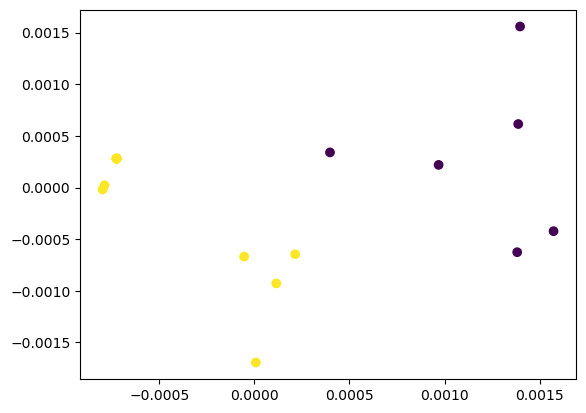

In [60]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch.optim as optim

# Prepare data for GCN (convert gene expression matrix to PyTorch tensor)
x = torch.tensor(expression_matrix, dtype=torch.float)

# Initialize model and optimizer
model = GCNCellClustering(in_channels=x.shape[1], hidden_channels=64, out_channels=32)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    # Forward pass through the GCN
    embeddings = model(x, edge_index)
    loss = torch.mean(embeddings.norm(dim=1))  # Unsupervised loss
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

# Apply k-means clustering on the learned embeddings
model.eval()
with torch.no_grad():
    embeddings = model(x, edge_index).cpu().numpy()

# Use PCA to reduce dimensionality (optional)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Plot the clustered cells
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.show()


In [56]:
embeddings.shape

(20, 32)

In [14]:
import numpy
print(numpy.__version__)

1.26.4


__Clustering Interpretation__

- K-Means Clustering: After training the GCN, we use k-means clustering to group the cells into distinct clusters. The assumption is that cells of the same type will have learned similar embeddings, making them easier to cluster.
- Dimensionality Reduction (PCA): To visualize the clustering in 2D, we can apply PCA to reduce the dimensionality of the learned representations.

__Benefits of Using GCN for Single-Cell Clustering:__

- Graph Structure: A GCN naturally leverages the graph structure that captures relationships (e.g., gene expression similarity) between cells, which can improve clustering performance.
- Feature Propagation: GCN layers aggregate information from neighboring nodes (cells), allowing the model to capture local and global structure in the dataset.
- Unsupervised Learning: GCNs can be trained without labels, making them ideal for exploratory tasks like cell-type discovery.

__Conclusion:__

By building a graph from single-cell RNA-seq data and applying a GCN, we can effectively learn cell representations and cluster them based on their gene expression profiles. The process combines the power of graph-based learning with clustering techniques to reveal meaningful patterns in the data, such as distinct cell types in a biological sample.

## Graph Attention Networks example: cell type classifier


__Generate a Synthetic Multi-Class Single-Cell Dataset__

For simplicity, we will again simulate a small dataset where cells belong to three different cell types. Each cell will have a gene expression vector, and the goal is to classify cells into their respective types. By applying a Graph Attention Network (GAT) to this synthetic single-cell dataset, we can classify cells into their respective types. The attention mechanism allows the model to weigh the importance of neighboring cells, making it highly effective for learning from graph-structured biological data such as single-cell RNA sequencing datasets.

In [61]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

# Create a synthetic single-cell RNA-seq dataset with 3 cell types
np.random.seed(42)
num_cells = 300
num_genes = 50

# Simulate gene expression profiles for 3 different cell types
cell_type_1 = np.random.normal(loc=2.0, scale=1.0, size=(100, num_genes))
cell_type_2 = np.random.normal(loc=0.0, scale=1.0, size=(100, num_genes))
cell_type_3 = np.random.normal(loc=-2.0, scale=1.0, size=(100, num_genes))

# Combine into a single dataset
gene_expression = np.vstack([cell_type_1, cell_type_2, cell_type_3])
labels = np.array([0] * 100 + [1] * 100 + [2] * 100)  # Cell type labels
# Normalize the data
scaler = StandardScaler()
gene_expression = scaler.fit_transform(gene_expression)

# Use PCA to reduce dimensionality (optional, but useful for visualization)
pca = PCA(n_components=10)
gene_expression_pca = pca.fit_transform(gene_expression)
# Convert to PyTorch tensors
x = torch.tensor(gene_expression_pca, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

__Create the Graph__

We'll create a graph where each node represents a cell, and edges represent similarity between cells based on their gene expression. For simplicity, we'll create a fully connected graph with weighted edges based on the Euclidean distance between cells.

In [62]:
from sklearn.metrics.pairwise import euclidean_distances

# Create a fully connected graph with distances as edge weights
distance_matrix = euclidean_distances(gene_expression_pca)
adjacency_matrix = np.exp(-distance_matrix / distance_matrix.std())  # Gaussian kernel
# Convert the adjacency matrix to edge_index and edge_attr format for PyG
edge_index, edge_weight = dense_to_sparse(torch.tensor(adjacency_matrix, dtype=torch.float))
# Create the PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
print(data)

Data(x=[300, 10], edge_index=[2, 90000], edge_attr=[90000], y=[300])


__Define and Train the GAT Model__

Next, we'll define a simple Graph Attention Network (GAT) using torch_geometric. The model will use the attention mechanism to weigh the importance of neighboring cells when classifying each cell.

In [63]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Define the Graph Attention Network
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        # First layer of GAT with attention
        x = F.elu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.6, training=self.training)
        # Second layer of GAT for output (cell type classification)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GAT(in_channels=10, hidden_channels=8, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the GAT model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluate the GAT model
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    accuracy = correct / data.num_nodes
    return accuracy

# Train the model for a few epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        accuracy = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch: 000, Loss: 3.0026, Test Accuracy: 0.0200
Epoch: 010, Loss: 1.2802, Test Accuracy: 0.3333
Epoch: 020, Loss: 1.2053, Test Accuracy: 0.3333
Epoch: 030, Loss: 1.0826, Test Accuracy: 0.3333
Epoch: 040, Loss: 1.0627, Test Accuracy: 0.3333
Epoch: 050, Loss: 1.0209, Test Accuracy: 0.3333
Epoch: 060, Loss: 0.9878, Test Accuracy: 0.4733
Epoch: 070, Loss: 0.9236, Test Accuracy: 0.3833
Epoch: 080, Loss: 0.9246, Test Accuracy: 0.3700
Epoch: 090, Loss: 0.9140, Test Accuracy: 0.3333


In [64]:
# Final evaluation after training
accuracy = test()
print(f'Final Test Accuracy: {accuracy:.4f}')

Final Test Accuracy: 0.3333


# Explanation of Results

- The GAT model dynamically learns to assign attention weights to neighboring cells based on their gene expression similarities.
- Each node's feature (cell's gene expression) is updated by aggregating information from its neighbors, weighted by the learned attention coefficients.
- The model uses two layers: the first layer computes attention scores, and the second layer produces the final cell type predictions.
- The model outputs the predicted cell type for each node, and the test accuracy gives us the proportion of cells correctly classified.

__Problems?__

The issue we are facing is that the accuracy is 0.3333. This is equivalent to random guessing for a 3-class problem. The loss is decreasing, which typically suggests that the model is learning something, but it may not be learning in a way that impacts classification performance. Several factors could be contributing to this:
- Class imbalance or label shuffling: Make sure that the labels are assigned correctly and not shuffled or misaligned with the input data. In a synthetic dataset, if labels are not properly assigned, it could result in poor performance.
- Over-smoothing: In graph-based models like GAT, information from neighbors is aggregated. If the model over-smooths (aggregates too much from neighbors), the node features could become too similar, making classification difficult. To avoid over-smoothing, try experimenting with fewer GAT layers. Two GAT layers are often enough, but reducing or adjusting the size of the hidden channels could help prevent the model from aggregating too much information.
- Edge weights and graph structure: Fully connected graphs (with an edge between every node) can sometimes overwhelm the attention mechanism, making it difficult for the model to learn meaningful differences between nodes. You might want to reduce the number of edges to focus more on local cell similarities rather than a dense, fully connected structure.
- Learning rate or hyperparameters: The learning rate might be too low or too high, which can result in poor training. Try experimenting with the learning rate and the number of attention heads. The most basic option is to initialize the model with different seeds. Since the performance of GAT can be sensitive to initialization, try setting a different seed for reproducibility and performance stabilization.
- Overfitting: If the model is too complex for the simple synthetic dataset, it may be overfitting. Adding regularization techniques like dropout or weight decay could help.


__Attempted solutions__

- Reduce Graph Density: A fully connected graph might not be ideal for this task. Let's try using a k-nearest neighbors (KNN) graph to reduce the number of edges and make the graph more sparse, focusing the model on local similarities rather than global ones.
- Adjust Learning Rate and Dropout: We are adjusting the learning rate and the dropout rate to improve performance. Let's decrease the learning rate and increase dropout to reduce overfitting.
- Monitor Over-smoothing: To avoid over-smoothing, try experimenting with fewer GAT layers. Two GAT layers are often enough, but reducing or adjusting the size of the hidden channels could help prevent the model from aggregating too much information. In our case we eliminated the weight channel from the GAT.


In [65]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate the synthetic single-cell RNA-seq dataset
np.random.seed(42)
num_cells = 300
num_genes = 50

cell_type_1 = np.random.normal(loc=2.0, scale=1.0, size=(100, num_genes))
cell_type_2 = np.random.normal(loc=0.0, scale=1.0, size=(100, num_genes))
cell_type_3 = np.random.normal(loc=-2.0, scale=1.0, size=(100, num_genes))

gene_expression = np.vstack([cell_type_1, cell_type_2, cell_type_3])
labels = np.array([0] * 100 + [1] * 100 + [2] * 100)

# Normalize and apply PCA for dimensionality reduction
scaler = StandardScaler()
gene_expression = scaler.fit_transform(gene_expression)
pca = PCA(n_components=10)
gene_expression_pca = pca.fit_transform(gene_expression)

x = torch.tensor(gene_expression_pca, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Create a k-nearest neighbors graph
k = 10
adjacency_matrix_knn = kneighbors_graph(gene_expression_pca, n_neighbors=k, mode='connectivity', include_self=True)
edge_index, _ = dense_to_sparse(torch.tensor(adjacency_matrix_knn.toarray(), dtype=torch.float))

# Create the PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model and optimizer
model = GAT(in_channels=10, hidden_channels=8, out_channels=3, heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Training and evaluation functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    accuracy = correct / data.num_nodes
    return accuracy

# Train the model
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        accuracy = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch: 000, Loss: 1.5666, Test Accuracy: 0.4700
Epoch: 010, Loss: 1.1289, Test Accuracy: 0.4900
Epoch: 020, Loss: 0.9075, Test Accuracy: 0.7967
Epoch: 030, Loss: 1.1501, Test Accuracy: 0.8300
Epoch: 040, Loss: 0.6872, Test Accuracy: 0.8467
Epoch: 050, Loss: 0.6313, Test Accuracy: 0.8833
Epoch: 060, Loss: 0.6732, Test Accuracy: 0.9133
Epoch: 070, Loss: 0.5575, Test Accuracy: 0.9467
Epoch: 080, Loss: 0.5404, Test Accuracy: 0.9600
Epoch: 090, Loss: 0.4871, Test Accuracy: 0.9733


__A few extra remarks:__


__On estimating the number of hidden channels:__
- The number of hidden channels is typically determined empirically, starting with a reasonable value based on the size of the input and output, and adjusted based on performance. For complex datasets (overlapping classes, high-dimensional input), you might need more hidden units, while simpler datasets ((with clear separations between classes) may require fewer.
- The number of hidden channels (also known as hidden units or hidden dimensions) in a neural network, including Graph Attention Networks (GAT), determines the size of the feature space that each layer outputs. Selecting the number of hidden channels is often a balance between model capacity (the ability to learn complex patterns) and the risk of overfitting or making the model too complex.
- Typically, the number of hidden channels is chosen as a value between the size of the input features (in_channels) and the number of output classes (out_channels). If the model has a high number of input features or needs to learn complex interactions, you might choose more hidden channels. For example, if the input is 10-dimensional (after PCA) and the output is 3 classes, you might choose a hidden channel size between 8 and 32.
- Use powers of 2. A common practice in deep learning is to set the number of hidden channels as powers of 2, which often helps in optimizing GPU-based operations. In practice, you may start with a smaller value like 8 or 16 and increase it if the model underfits (i.e., fails to capture the complexity of the data).
- __Exercise__ Grid Search or Hyperparameter Tuning. You can perform hyperparameter tuning using cross-validation or grid search to find the optimal number of hidden channels. Start with a small number of hidden units and gradually increase them until you observe a significant improvement in performance. Try different values such as 8, 16, 32, 64, and measure the model's accuracy on a validation set. Choose the number that provides the best trade-off between accuracy and computational complexity. If the model does not perform well or underfits increase the hidden dimension, or reduce it if overfitting occurs.


__How to estimate the number of heads and other parameters in the multi-heated attention layer?__
- Heads refer to the concept of *multi-head attention*, which is borrowed from the attention mechanism in models like Transformers. In the GAT architecture, the attention mechanism computes attention coefficients between neighboring nodes in a graph to determine their importance during feature aggregation. Multi-head attention involves running multiple independent attention mechanisms (or heads) in parallel. In short, instead of computing a single attention coefficient for each edge (connection between nodes), GAT computes several independent attention scores (one for each "head"). Each attention head aggregates the features of neighboring nodes in a slightly different way, allowing the model to capture different types of relationships or patterns between nodes. This way, by learning different attention weights for a given node and its neighbors different heads can focus on different relationships or node features,
enabling the model to capture a variety of patterns.
- Stabilizing the Learning Process: Multi-head attention improves the robustness and stability of the learning process. By having multiple attention heads, the model can "look" at different aspects of the neighborhood, making it less likely to overfit to specific attention weights. In the GAT layer (GATConv) we are using 4 independent attention mechanisms in parallel.
- Feature Aggregation Across Heads: If the attention heads' outputs are concatenated (when concat=True), the dimensionality of the output from each node increases. For example, if you have 8 heads and each head produces 16 features, the final node representation would have 8 x 16 = 128 dimensions. Averaging (when concat=False) instead of concatenating the output from each head keeps the output dimensionality fixed.
- Summary:
    - in_channels=10: Each node initially has 10 features (e.g., after dimensionality reduction with PCA).
    - out_channels=8: Each attention head outputs 8 features for each node.
    - heads=4: There are 4 independent attention heads. With concatenation (concat=True), the output for each node will be 8 x 4 = 32 features
    - If concat=False, the output dimension will remain 8, as the outputs from the 4 heads will be averaged instead of concatenated.


__How to defend the pick of a certain loss function?__
- Cross Entropy Loss is the most appropriate loss function for multi-class classification tasks, which is the case in your problem of identifying cell types. For multi-class classification, the Cross Entropy Loss is commonly used because it measures the difference between the true label (one-hot encoded) and the predicted probability distribution over the classes. The loss encourages the model to output high probabilities for the correct class while minimizing the probabilities for the incorrect ones.
- How Cross Entropy Loss Works. In PyTorch, the CrossEntropyLoss combines the softmax and negative log-likelihood in one function, which is why we don’t need to manually apply softmax in the model's output layer. The model's final layer typically outputs raw scores (logits), and Cross Entropy Loss first applies a softmax function to convert these logits into probabilities. Then, it applies the logarithmic loss to penalize wrong predictions more severely, particularly when the model is highly confident but wrong.
- Comparison to Other Loss Functions. Here’s why Cross Entropy Loss is more appropriate than some other common loss functions:
    - Mean Squared Error (MSE): This is typically used for regression tasks (predicting continuous values). It is not well-suited for classification because it does not focus on minimizing the difference between the predicted probabilities and the correct class probabilities.
    - Binary Cross Entropy: This is used for binary classification (two classes). In your case, you have more than two classes, so multi-class Cross Entropy Loss is the correct choice.

__Why was ELU used?__
- The function F.elu in PyTorch applies the Exponential Linear Unit (ELU) activation function to the input tensor. ELU is a type of non-linear activation function used in neural networks, designed to introduce non-linearity into the model while helping to address some of the problems associated with other activation functions, such as the vanishing gradient problem.
- Non-linearity: Like ReLU (Rectified Linear Unit) and other activation functions, ELU introduces non-linearity into the model. This allows the neural network to capture more complex relationships between inputs and outputs.
- Smooth for negative inputs: For negative values of x, ELU outputs values that are smaller but never exactly zero. Unlike ReLU, which has a hard zero for negative inputs, ELU's negative side is smooth and continuous, which can result in better learning for some models.
- Helps with vanishing gradient: ELU, unlike functions like Sigmoid or Tanh, avoids the vanishing gradient problem for positive inputs because the gradient of x for positive values is 1. For negative values, the gradient approaches 0 but not as quickly as in other functions like Sigmoid, which might reduce the gradient magnitude too early.
- Negative saturation: ELU saturates for negative inputs, but in a smooth way. This helps the network push the weights in the negative direction if necessary, which can lead to faster convergence and better generalization in some cases.
- Zero-centered: ELU outputs values that are centered around zero, which helps in making gradient updates more balanced and can improve training speed compared to ReLU, which only outputs positive values.
- Comparison to Other Activation Functions:
    - ReLU: ReLU outputs x for positive inputs and zero for negative inputs. The problem with ReLU is that for large negative inputs, the gradient is zero (known as the dying ReLU problem). ELU addresses this issue by giving non-zero, smooth gradients for negative inputs.
    - Leaky ReLU: Leaky ReLU is a variation of ReLU where a small, constant gradient is allowed for negative inputs. ELU differs from this because the gradient for negative values is not constant but instead exponentially approaches zero, providing smoother updates.
    - Sigmoid / Tanh: These activation functions suffer from the vanishing gradient problem when inputs are far from zero. ELU addresses this by having gradients closer to 1 for positive inputs.

__How to adjust dropout rate?__
- Similar to how the human mind learns to neglect unimportant features, dropout is a regularization technique that randomly drops a fraction of neurons during training to prevent overfitting. The parameter p controls the dropout rate (the fraction of neurons to be dropped). Typical values range from 0.2 to 0.6. Dropout is only applied during training (training=self.training), and it is automatically disabled during evaluation. You can adjust the dropout rate based on performance (validation accuracy) to balance between overfitting and underfitting.
- Small models or small datasets: Use higher dropout (.5, .6) to avoid overfitting. This ensures the model does not memorize the data too quickly. Large models or large datasets: Use smaller dropout (.2, .3). For large datasets, the risk of overfitting is lower, so less regularization is needed.
- Where to Apply Dropout: In GAT, or any neural network, dropout can be applied:
    - Between layers: After a GAT or fully connected layer, to regularize the learned representations.
    - Before the output layer: Sometimes dropout is used right before the output layer to prevent the model from relying on specific features.
- __Exercise__ Start with a common value such as 0.5 and if you notice overfitting (i.e., high training accuracy but low validation accuracy), increase the dropout rate, while if you notice underfitting (i.e., both training and validation accuracies are low), decrease the dropout rate (to 0.3 or 0.2). Use cross-validation: You can experiment with different dropout rates using cross-validation on your validation set to find the rate that performs best.
